Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolas Guarín-Zapata 2019. Este material es parte del curso Mecánica de los Medios Continuos en el programa de Ingeniería Civil de la Universidad EAFIT.

# Análisis de deformación.
(Medios Continuos)

### Introducción

En una gran cantidad de casos prácticos es necesario determinar el campo de desplazamientos, tensiones y deformaciones unitarias por medio de simulaciones numéricas, por ejemplo con el método de los elementos finitos. Por lo tanto a la hora de resolver problemas complejos es importante que el igeniero sea competente en el proceso de construcción de modelos e interpretación de soluciones numéricas. En este notebook estudiaremos como problema fundamental el campo de deformaciones en un punto material sometido a diferentes modos de deformación. **Al completar este notebook usted debe estar en capacidad de:**

* Identificar las aproximaciones necesarias en la modelación de un punto material mediante un modelo por elementos finitos.

* Identificar las forma correcta de imponer condiciones de frontera en el modelo por elementos finitos para un punto material.

* Identificar los modos de deformación (compresion, tracción, distorsión) que puede tener un punto material de un medio a través de resultados típicos de simulaciones numéricas.

## Rutinas para el análisis

Importación de los modulos para el análisis.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import meshio
import solidspy.preprocesor as msh
import solidspy.assemutil as ass
import solidspy.postprocesor as pos
import solidspy.solutil as sol
from matplotlib.tri import Triangulation, CubicTriInterpolator

Lectura de archivos de texto.

In [2]:
def readin():
    nodes = np.loadtxt('files/Rnodes.txt', ndmin=2)
    mats  = np.loadtxt('files/Rmater.txt', ndmin=2)
    elements = np.loadtxt('files/Reles.txt', ndmin=2, dtype=np.int)
    loads = np.loadtxt('files/Rloads.txt', ndmin=2)
    return nodes, mats, elements, loads

Rutina para visualizar mallas.

In [3]:
def viewmesh(nodes , elements , view = False):
    #
    """Generates and displays a matplotlib.tri.Triangulation object created from a
       user defined finite element mesh given by nodes and elements.

    Parameters
    ----------
    nodes : ndarray (float)
      Array with number and nodes coordinates:
        `number coordX coordY BCX BCY`
    elements : ndarray (int)
      Array with the node number for the nodes that correspond to each
      element.

    Returns
    -------
    tri : Triangulation
        An unstructured triangular grid consisting of npoints points
        and ntri triangles.

    """
    x = nodes[:, 1]
    y = nodes[:, 2]
    triangs = []
    for el in elements:
        if el[1]==2:
            triangs.append(el[[3, 4, 5]])
            triangs.append(el[[5, 6, 3]])
        if el[1]==9:
            triangs.append(el[[3, 6, 8]])
            triangs.append(el[[6, 7, 8]])
            triangs.append(el[[6, 4, 7]])
            triangs.append(el[[7, 5, 8]])
        if el[1]==3:
            triangs.append(el[3:])

    tri = Triangulation(x, y, np.array(triangs))
#
    if view:
        plt.figure(0)
        plt.gca().set_aspect('equal')
        plt.triplot(tri, lw=0.5, color='red')

    return tri

Rutina para graficar la configuración deformada del modelo.

In [4]:
def deformed_config(nodes , elements , scale_fact):
    nodes_def = nodes[:, 1:3] + scale_fact*UC
    plt.figure()
    plt.triplot(nodes[:, 1], nodes[:, 2], elements[:, -3:], color="gray", alpha=0.5)
    plt.triplot(nodes_def[:, 0], nodes_def[:, 1], elements[:, -3:])

### Script de procesado de la malla

In [5]:
mesh = meshio.read("files/rve.msh")
points     = mesh.points
point_data = mesh.point_data
cells      = mesh.cells
cell_data  = mesh.cell_data

nodes_array    = msh.node_writer(points, point_data)
nf , els_array = msh.ele_writer(cells, cell_data, "triangle", 100, 3, 0, 0)
nodes_array    = msh.boundary_conditions(cells, cell_data, 100, nodes_array, 0 , -1)
nodes_array    = msh.boundary_conditions(cells, cell_data, 300, nodes_array, -1, -1)
np.savetxt("files/Reles.txt", els_array, fmt="%d")
np.savetxt("files/Rnodes.txt", nodes_array, fmt=("%d", "%.4f", "%.4f", "%d", "%d"))

## Planteamiento del problema.

Claramente la definición de punto material usada en el modelo del medio continuo es una abstracción matemática sobre la cual aplicamos leyes de la física. En dicho contexto el punto material no tiene tamaño ni forma. Sin embargo en el modelo del continuo es común representarlo mediante un cubo (cuadrado en el caso plano), ya que esto facilita el análisis en un sistema de referencia cartesiano. Sin embargo, en una simulación por el método de los elementos finitos no es posible representar de manera exacta el punto material, sino que este es aproximado precisamente mediante un elemento finito. Para que los resultados de los modelos numéricos puedan aproximar de manera correcta la respuesta mecánica de los medios es natural esperar que el elemento sea capaz de deformrse como un puto material a medida que su tamaño es lo suficientemente pequeño.

En esta actividad, para estudiar la respuesta mecánica de un punto material, vamos a asumir que en el modelo por elementos finitos el mismo tiene un tamaño de $1.0m \times 1.0m$. **(Discuta con su profesor las implicaciones de asumir este tamaño para el punto material)** . Para estudiar el problema aplicaremos de manera independiente tensiones $\sigma$ y $\tau$ sobre la frontera superior del modelo. El medio tiene modulo de elasticidad $E = 50.0 GPa$ y relación de Poisson $\nu = 0.3$.

(Para ver la malla del modelo ejecute el siguiente bloque de código)



<div class="alert alert-warning">

Discuta con su profesor cuales deben ser las condiciones de frontera correctas para el modelo por elementos finitos de manera que capture apropiadamente los modos de deformación.
</div>

<IPython.core.display.Javascript object>


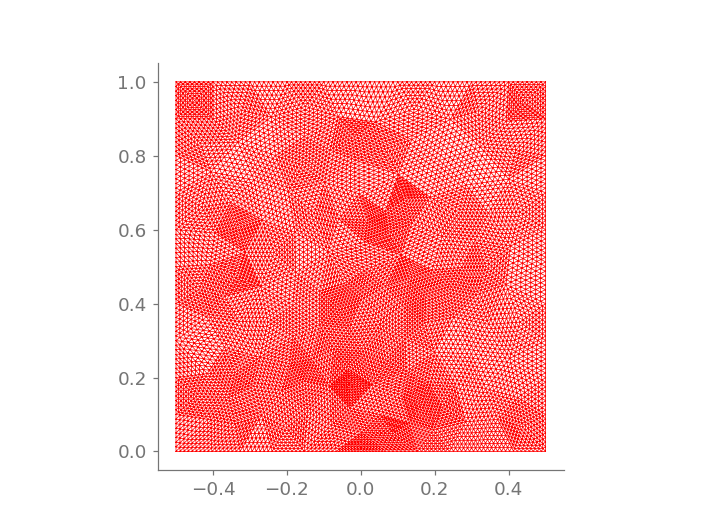

In [6]:
nodes, mats, elements, loads = readin()
trii = viewmesh(nodes , elements , True)

### Análisis

En el método de los elementos finitos las tracciones son convertidas a fuerzas puntuales de tal forma que la carga total consistente con la tracción $\sigma$ esta dada por $F_T = \sigma \times l$ donde $l$ es el tamaño del elemento. En este caso hagamos $\sigma = 1.0 MPa$.



<div class="alert alert-warning">

¿Antes de ejecutar el análisis trate de predecir para este valor de la carga y propiedades de material cual es el valor esperado de las deformaciones y los desplazamientos en las direcciones $x$ y $y$ para las diferentes condiciones de carga
</div>

In [7]:
cargas = msh.loading(cells, cell_data, 200 , 0.0 , -1.0e6)
np.savetxt("files/Rloads.txt", cargas, fmt=("%d", "%.3g", "%.3g"))

In [8]:
DME, IBC, neq = ass.DME(nodes, elements)
mat_rigidez = ass.assembler(elements, mats, nodes, neq, DME)
force_vec = ass.loadasem(loads, IBC, neq)
UG = sol.static_sol(mat_rigidez, force_vec)
UC = pos.complete_disp(IBC, nodes, UG)

Grafiquemos la configuración deformada:

<IPython.core.display.Javascript object>


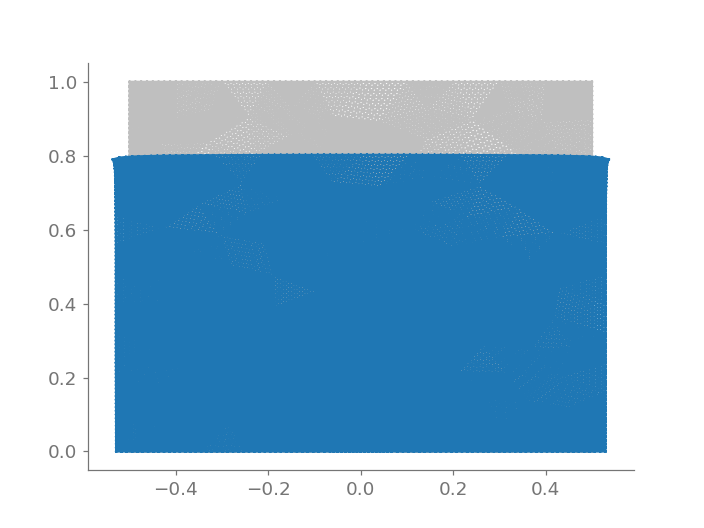

In [9]:
deformed_config(nodes , elements , scale_fact = 1.0e4)

<div class="alert alert-warning">

Antes de calcular y visualizar los resultados de desplazamientos y deformaciones unitarias trate de anticipar como se deben ver los resultados. Tenga en cuenta que en el método de los elementos finitos es usual visualizar los resultados de campos vectoriales y tensoriales en terminos de contornos (curvas de nivel) correspondientes a cada una de las componentes escalares.

Con su equipo de trabajo trate de dibujar los contornos a mano para cada una de las componentes del vector de desplazamientos y del tensor de deformaciones unitarias.

Que explicación da a las diferencias encontradas?
</div>

<IPython.core.display.Javascript object>


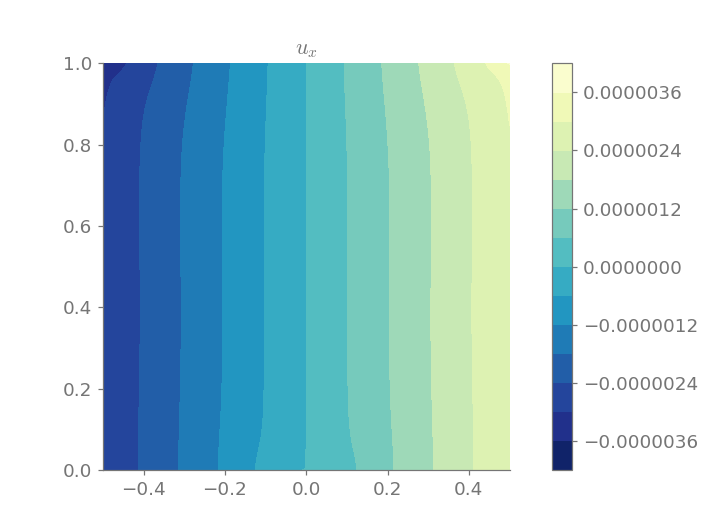

C:\Users\AX201 GMRS\Anaconda3\lib\site-packages\solidspy\postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


<IPython.core.display.Javascript object>


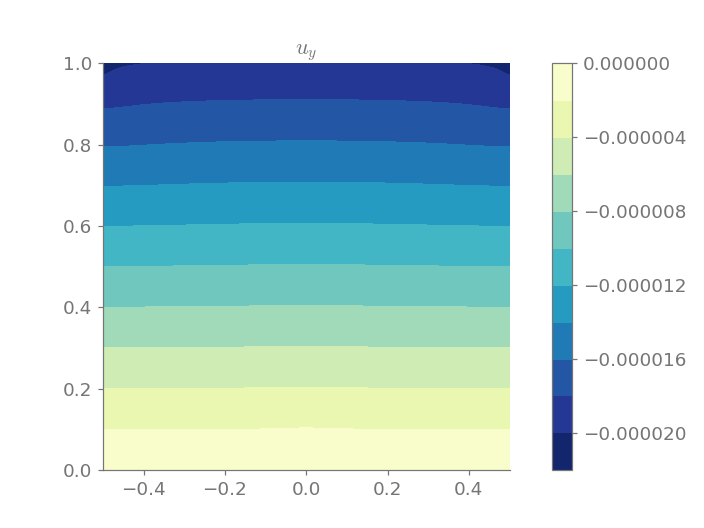

<IPython.core.display.Javascript object>


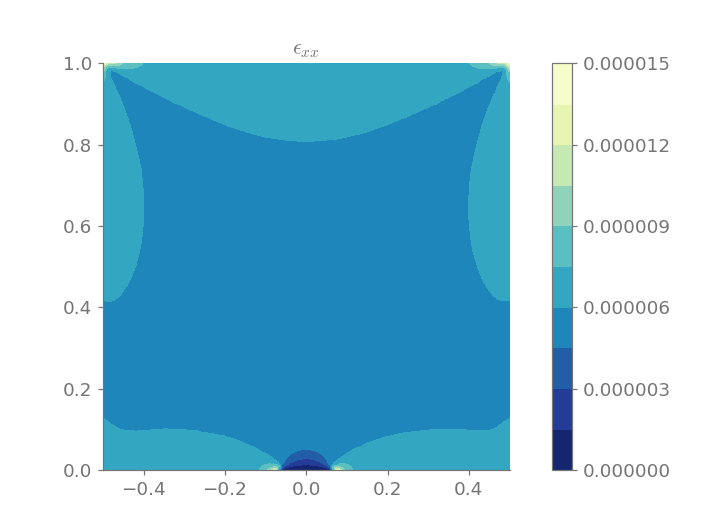

<IPython.core.display.Javascript object>


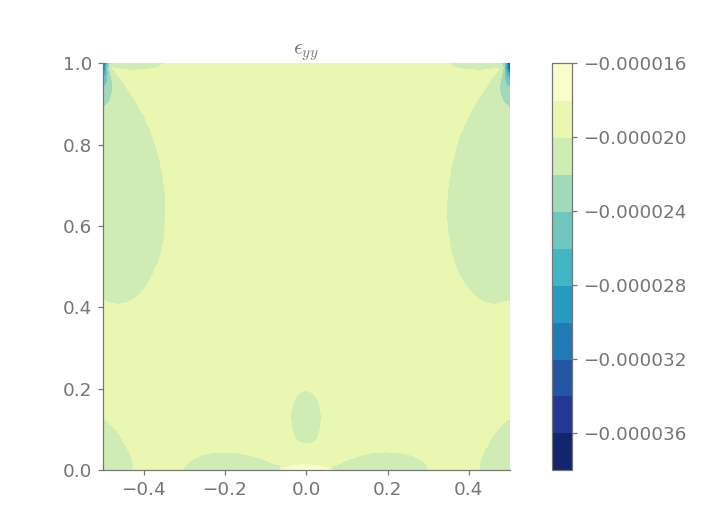

<IPython.core.display.Javascript object>


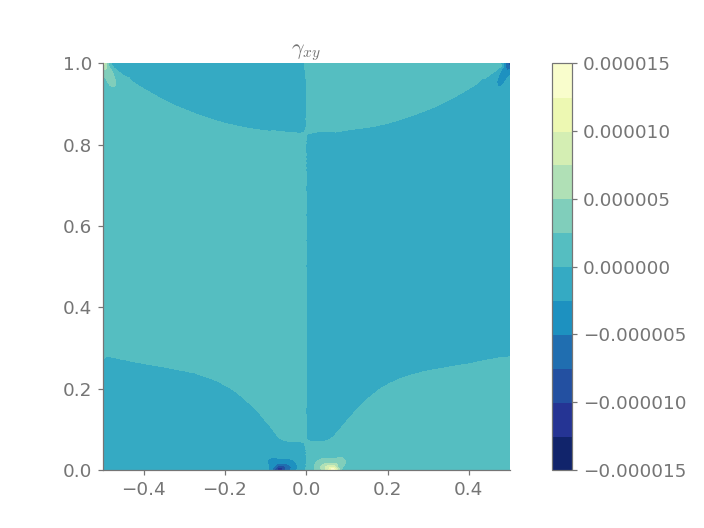

In [10]:
E_nodes, S_nodes = pos.strain_nodes(nodes, elements, mats, UC)
pos.fields_plot(elements, nodes, UC, E_nodes=E_nodes)

### Tracción y cortante

Repita el análisis si la carga es ahora aplicada en tracción y cortante respectivamente. De manera similar trate de aplicar cargas en 2 direcciones perpendiculares y repita el análisis.

### Solución sobre un dominio completo

Habiendo estudiado el comportamiento de un punto material ante diferentes modos de deformación como cree que son los contornos para el vector de desplazamientos y para el tensor de deformaciones en el problema de Boussinesq?

### Referencias

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

In [11]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()